# AGW Tutorial

In this tutorial, we will examine our newest tool, AGW. AGW blends together UGW and UCOOT to incentivise sample alignments that are informed by both feature correspondence and local geometry. We will again use the CITEseq dataset from earlier tutorials, with the goal of recovering the underlying 1-1 alignment of the 1000 samples by considering expression and antibody data separately.

```{tip}
If you have not yet configured a SCOT+ directory of some kind, see our installation instructions markdown. Once you complete those steps or set up your own virual environment, continue on here.

If you aren't sure what any of the parameters for setting up a Solver object mean, try our setup tutorial for getting used to using the tool.

If you are looking for more detail on what the parameters of the alignment do in practice, start by visiting our UGW, UCOOT, and fused formulation tutorials. We will draw on all of these when examining AGW.

If you are unsure what some of the notation means throughout the rest of this document, try reading our optimal transport theory section to get more comfortable.

If you already know how to use AGW, continue on to the next chapter: our explorations of how AGW can be applied!
```

### Preprocessing

As usual, we set up PyTorch:

In [1]:
import torch
print('Torch version: {}'.format(torch.__version__))
print('CUDA available: {}'.format(torch.cuda.is_available()))
print('CUDA version: {}'.format(torch.version.cuda))
print('CUDNN version: {}'.format(torch.backends.cudnn.version()))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark=True

Torch version: 2.1.0
CUDA available: False
CUDA version: None
CUDNN version: None


To begin, we will load in our preprocessed data. If you would like to preprocess the data in your own way, you can download the raw files for this dataset by running "sh download_scripts/CITEseq_download.sh" from the root of your SCOT+ directory. They will be loaded into the same folder as the preprocessed datasets.

In [2]:
%%capture
from scotplus.solvers import SinkhornSolver
from scotplus.utils.alignment import compute_graph_distances, get_barycentre, calc_domainAveraged_FOSCTTM
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import normalize
plt.rcParams['font.family'] = 'Helvetica Neue'

adt_raw = sc.read_csv("./data/CITEseq/citeseq_adt_normalized_1000cells.csv")
rna_raw = sc.read_csv("./data/CITEseq/citeseq_rna_normalizedFC_1000cells.csv")
adt_feat_labels=["CD11a","CD11c","CD123","CD127-IL7Ra","CD14","CD16","CD161","CD19","CD197-CCR7","CD25","CD27","CD278-ICOS","CD28","CD3","CD34","CD38","CD4","CD45RA","CD45RO","CD56","CD57","CD69","CD79b","CD8a","HLA.DR"]
rna_feat_labels=["ITGAL","ITGAX","IL3RA","IL7R","CD14","FCGR3A","KLRB1","CD19","CCR7","IL2RA","CD27","ICOS","CD28","CD3E","CD34","CD38","CD4","PTPRC","PTPRC","NCAM1","B3GAT1","CD69","CD79B","CD8A","HLA-DRA"] 
samp_labels = ['Cell {0}'.format(x) for x in range(adt_raw.shape[1])]

From here, we can load our data into usable DataFrames, as in prior tutorials.

In [3]:
# l2 normalization of both datasets, which we found to help with single cell applications
adt_full_annotated = pd.DataFrame(normalize(adt_raw.X.transpose()))
rna_full_annotated = pd.DataFrame(normalize(rna_raw.X.transpose()))

# annotation of both domains
adt_full_annotated.index, adt_full_annotated.columns = samp_labels, adt_feat_labels
rna_full_annotated.index, rna_full_annotated.columns = samp_labels, rna_feat_labels

# gather full data in numpy
adt_full = adt_full_annotated.to_numpy()
rna_full = rna_full_annotated.to_numpy()

# subset annotated data
adt_annotated = adt_full_annotated.iloc[:,0:10]
rna_annotated = rna_full_annotated.iloc[:,0:10]

# gather subset in numpy
adt = adt_annotated.to_numpy()
rna = rna_annotated.to_numpy()

In order to keep our objective in mind, let's look at the UMAP/PCA of each domain pre-alignment one last time:

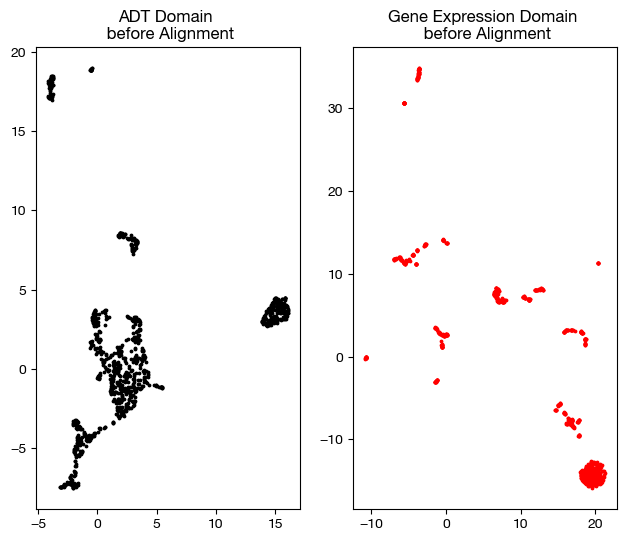

In [86]:
um = umap.UMAP(random_state=0)

original_adt_um=um.fit_transform(adt)
original_rna_um=um.fit_transform(rna)

#Visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12,5))
ax1.scatter(original_adt_um[:,0], original_adt_um[:,1], c="k", s=5)
ax1.set_title("ADT Domain \n before Alignment")
ax2.scatter(original_rna_um[:,0], original_rna_um[:,1], c="b", s=5)
ax2.set_title("Gene Expression Domain \n before Alignment")
plt.show()

findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.


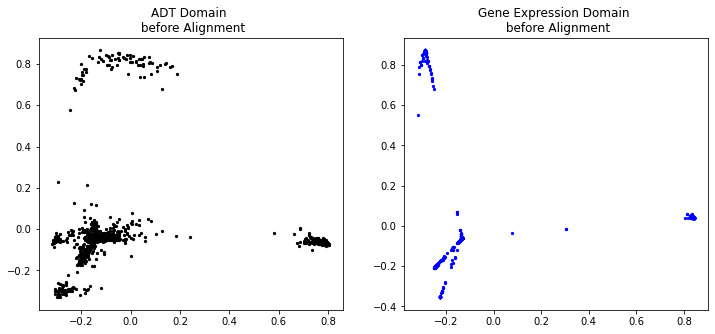

In [13]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2)

original_adt_pca=pca.fit_transform(adt)
original_rna_pca=pca.fit_transform(rna)

#Visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12,5))
ax1.scatter(original_adt_pca[:,0], original_adt_pca[:,1], c="k", s=5)
ax1.set_title("ADT Domain \n Before Alignment")
ax2.scatter(original_rna_pca[:,0], original_rna_pca[:,1], c="b", s=5)
ax2.set_title("Gene Expression Domain \n Before Alignment")
plt.show()

### Default AGW

Next, we can instantiate a Solver object to begin aligning our data.

In [4]:
scot = SinkhornSolver(nits_uot=5000, tol_uot=1e-3)

From here, we can begin by establishing pairwise distance matrices for our domains, as per the UGW tutorial:

In [9]:
# knn connectivity distance
D_adt_knn, D_rna_knn = torch.from_numpy(compute_graph_distances(adt, n_neighbors=10, mode='connectivity').astype('float32')).to(device), torch.from_numpy(compute_graph_distances(rna, n_neighbors=10, mode='connectivity').astype('float32')).to(device)

Now that we are all set up to run an alignment between $X$ and $y$, we will pause for a moment to examine what AGW is trying to do. As we did with UGW and UCOOT, let's examine the objective function that AGW is hoping to minimize. First, recall our UGW objective function:

$GW(\pi_s) = L_{GW}(D(x_i, x_j), D(y_k, y_l)) \cdot \pi_{s_{ij}} \cdot \pi_{s_{kl}}$ for all samples $i, j$ in $X$ and $k, l$ in $y$. Recall that $L_{GW}$ is euclidean distance for our purposes. Now, we re-examine the UCOOT objective function:

$COOT(\pi_s, \pi_f) = L_{COOT}(X_{ij}, y_{kl}) \cdot \pi_{s_{ik}} \cdot \pi_{f_{jl}}$ for all samples $i$ in $X$, features $j$ in $X$, samples $k$ in $y$, and features $l$ in $y$. Again, $L_{COOT}$ is euclidean distance for our purposes. Given these two functions, our AGW objective function is as follows:

$\alpha GW(\pi_s) + (1 - \alpha) COOT(\pi_s, \pi_f)$

```{warning}
Note that we have a new hyperparameter $\alpha$ – this is NOT the same $\beta$, which we called $\alpha$ in prior versions of the tool. In this case, $\alpha$ trades off how much we use GW versus COOT in our optimization procedure.
```

This AGW objective function allows us to continue employing BCD, considering that we can minimize the GW and COOT part of the costs iteratively. In this sense, each "block" consists of two blocks as we understood them in the UCOOT and UGW tutorials. A new parameter we can specify is nits_gw, which determines how many times we run a GW block (back and forth optimization of $\pi_s$ and $\pi_s'$, our copy of $\pi_s$ from GW) per COOT block (back and for optimization of $\pi_s$ and $\pi_f$)

AGW allows us to look at local geometry (GW) and feature correspondence (COOT) when optimizing a given $\pi_s$. If you would like more information on the theory behind why AGW works, look at our theory document early in this tutorial chapter. Let's try an alignment:

In [12]:
pi_samp, pi_samp_prime, pi_feat = scot.agw(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), D_adt_knn, D_rna_knn, alpha=0.1, eps=5e-2, verbose=False)

BCD Iteration 1 - Loss: 0.961545, 1.057994
BCD Iteration 2 - Loss: 0.958531, 1.057435
BCD Iteration 3 - Loss: 0.958473, 1.057461
BCD Iteration 4 - Loss: 0.958451, 1.057445
BCD Iteration 5 - Loss: 0.958461, 1.057456
BCD Iteration 6 - Loss: 0.958485, 1.057479
BCD Iteration 7 - Loss: 0.958496, 1.057490
BCD Iteration 8 - Loss: 0.958531, 1.057525
BCD Iteration 9 - Loss: 0.958531, 1.057525


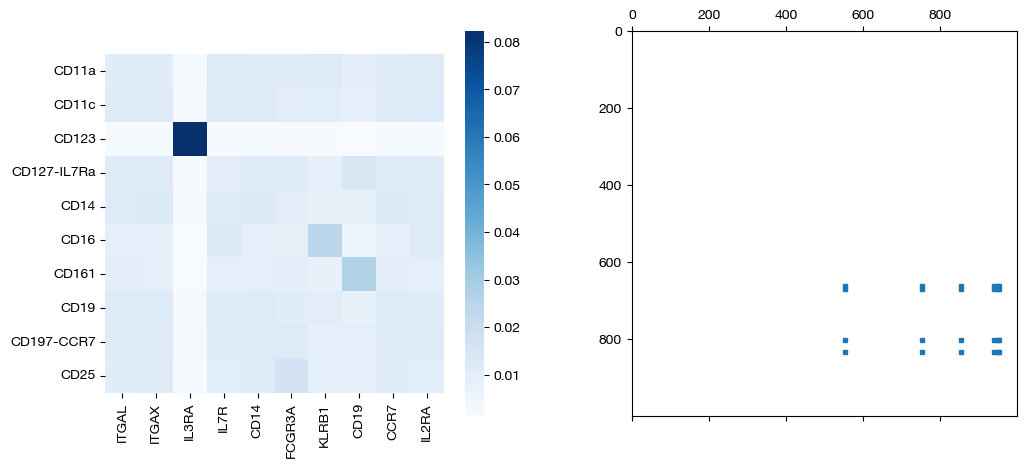

In [13]:
import seaborn as sns

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(pd.DataFrame(pi_feat, index=adt_annotated.columns, columns=rna_annotated.columns), ax=ax1, cmap='Blues', square=True)
sns.heatmap(pi_samp, cmap='Blues')
plt.show()

### Entropic Regularization

Entropic regularization functions the same as in prior tutorials – if you are curious about what entropic regularization does, look at the UGW or UCOOT tutorials. We can quickly show that this similarity holds by experimenting with a few different values of epsilon.

In [10]:
pi_samp_lg, _, pi_feat_lg = scot.agw(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), D_adt_knn, D_rna_knn, alpha=0.1, eps=1e-2, verbose=False)

pi_samp_med, _, pi_feat_med = scot.agw(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), D_adt_knn, D_rna_knn, alpha=0.1, eps=1e-1, verbose=False)

pi_samp_sm, _, pi_feat_sm = scot.agw(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), D_adt_knn, D_rna_knn, alpha=0.1, eps=1, verbose=False)

Delta: 0.00044686290929971757  Loss: 0.0657854184174504
Delta: 1.521497299167754e-19  Loss: 0.0657854197468621
converged at iter  5


/Users/colinbaker/anaconda3/envs/scootr/lib/python3.9/site-packages/ot/bregman.py:535: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Delta: 0.1802288114115536  Loss: 0.055967861688294734
Delta: 0.010965286773727498  Loss: 0.032290710230949406
Delta: 0.21318787281639032  Loss: 0.054730988776610937
Delta: 0.00014830720661730145  Loss: 0.028992096849389463


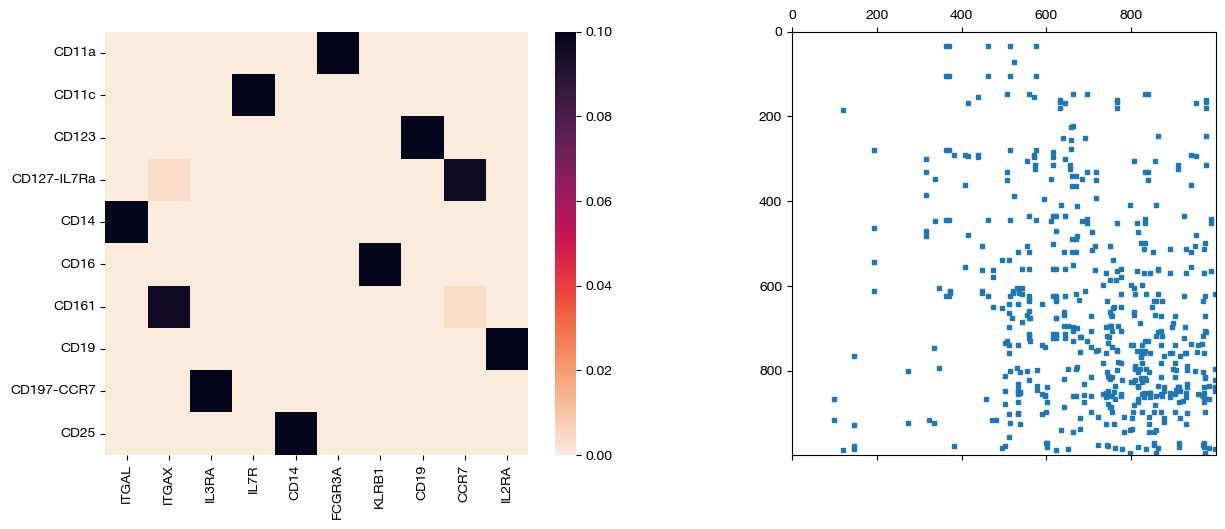

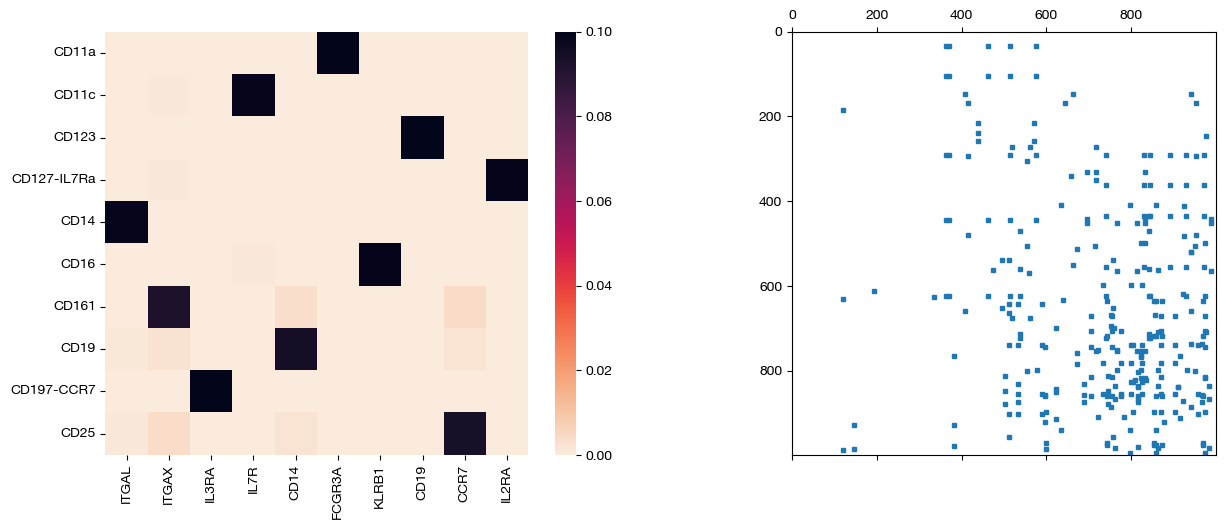

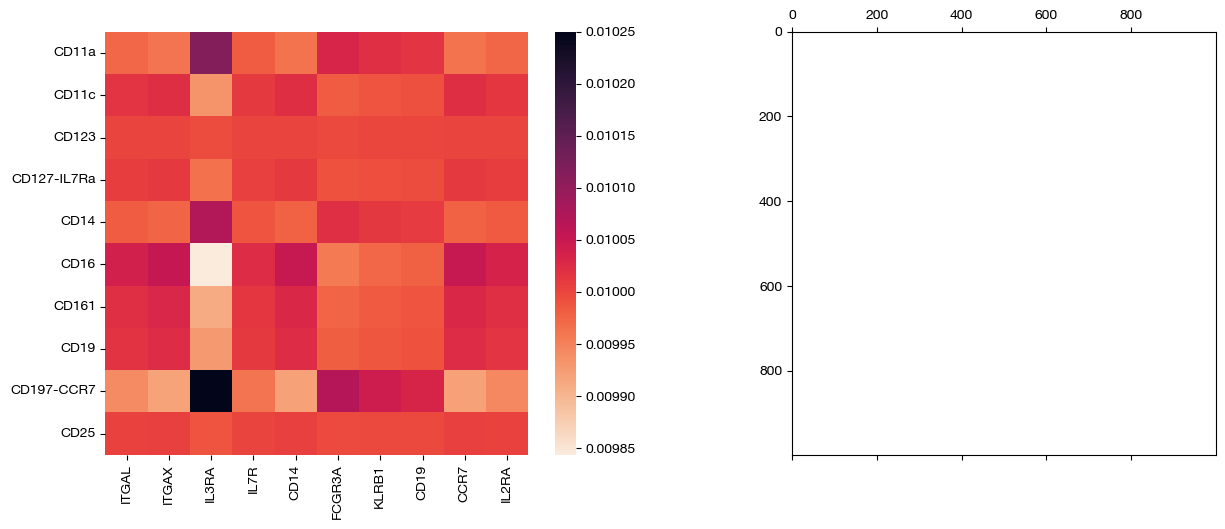

In [82]:
for pi_feat, pi_samp, size in [(pi_feat_sm, pi_samp_sm, 'eps=1e-2'), (pi_feat_med, pi_samp_med, 'eps=1e-1'), (pi_feat_lg, pi_samp_lg, 'eps=1')]:
    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    sns.heatmap(pd.DataFrame(pi_feat, index=adt_annotated.columns, columns=rna_annotated.columns), ax=ax1, cmap='Blues', square=True)
    sns.heatmap(pi_samp[:100,:100], cmap='Blues')
    plt.show()

As seen above, high epsilon still encourages density, while a low epsilon leads to more sparse coupling matrices.

### Marginal Relaxation

Unlike UGW and UCOOT, our current version of AGW does not allow for marginal relaxation (although, since our backend solver is fully generalized, you can experiment with the notion of it). We may add $\rho$ as a hyperparameter in the future, but for the moment, we do not support it. The lack of marginal relaxation in AGW places more emphasis on sample supervision and the initial distributions we use.

### Alpha and Balancing GW and COOT

Now, we can examine AGW closely. We will start by looking at $\alpha$, and then move on to algorithmic decisions and sample/feature supervision.

To start, we will compare the $\alpha = 0$ and $\alpha = 1$ cases to UGW and UCOOT, using the Sinkhorn algorithm (the common algorithm that both AGW and UGW/UCOOT use).

In [100]:
pi_samp_ngw, _, _ = scot.agw(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), D_adt_knn, D_rna_knn, alpha=1, eps=1e-2, verbose=False)

pi_samp_ogw, _, _ = scot.gw(D_adt_knn, D_rna_knn, eps=1e-2, verbose=False)

pi_samp_ncoot, _, pi_feat_ncoot = scot.agw(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), D_adt_knn, D_rna_knn, alpha=0, eps=1e-2, verbose=False)

pi_samp_ocoot, _, pi_feat_ocoot = scot.coot(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), eps=1e-2, verbose=False)

Now, we examine the feature coupling matrices from AGW with $\alpha=0$ and COOT:

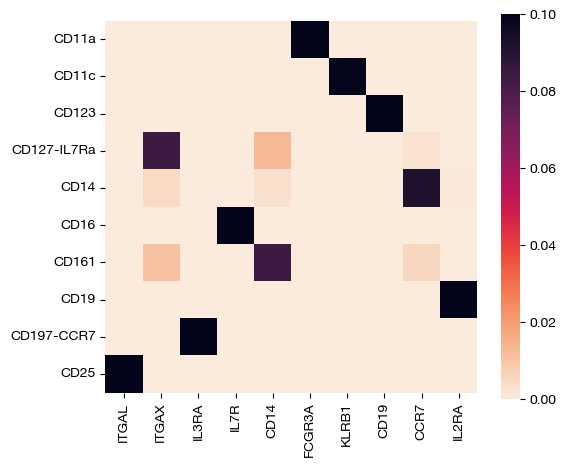

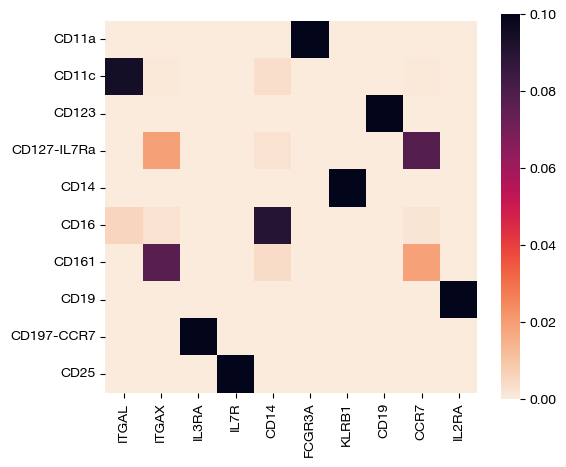

In [101]:
for pi_feat in pi_feat_ncoot, pi_feat_ocoot:
    sns.heatmap(pd.DataFrame(pi_feat, index=adt_annotated.columns, columns=rna_annotated.columns), cmap='Blues', square=True)
    plt.show()

As we can see above, we get identical reults (to be expected). From here, we can look at an intermediate value of $\alpha$, and compare visualizations with $\alpha=0$ and $\alpha=1$

In [14]:
pi_samp_half, _, pi_feat_half = scot.agw(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), D_adt_knn, D_rna_knn, alpha=0.5, eps=1e-2, verbose=False)

/Users/colinbaker/anaconda3/envs/scootr/lib/python3.9/site-packages/ot/bregman.py:535: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Delta: 0.18340653838250004  Loss: 0.05673939441886979
Delta: 0.002397163856033941  Loss: 0.03420606718202827


We begin by projecting and scoring these alignments:

In [15]:
aligned_rna_ngw = get_barycentre(adt, pi_samp_ngw)
aligned_rna_half = get_barycentre(adt, pi_samp_half)
aligned_rna_ncoot = get_barycentre(adt, pi_samp_ncoot)

Average FOSCTTM score for this alignment (alpha=0) with X onto Y is:  0.5207507507507507


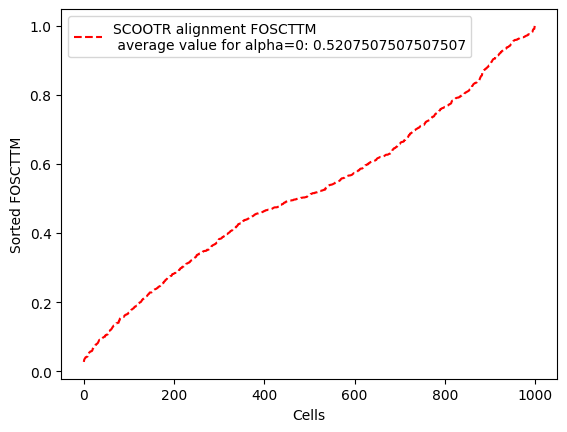

Average FOSCTTM score for this alignment (alpha=0.5) with X onto Y is:  0.5321211211211212


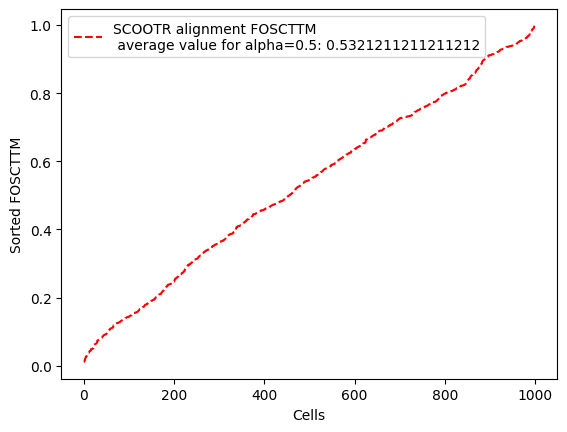

Average FOSCTTM score for this alignment (alpha=1) with X onto Y is:  0.5207507507507507


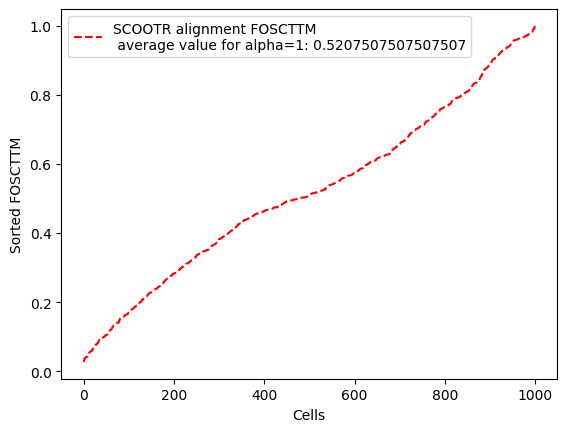

In [16]:
for aligned_rna, size in [(aligned_rna_ncoot, 'alpha=0'), (aligned_rna_half, 'alpha=0.5'), (aligned_rna_ngw, 'alpha=1')]:
    fracs = calc_domainAveraged_FOSCTTM(adt, aligned_rna.numpy())
    legend_label="AGW alignment FOSCTTM \n average value for {0}: ".format(size)+str(np.mean(fracs))
    plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
    plt.legend()
    plt.xlabel("Cells")
    plt.ylabel("Sorted FOSCTTM")
    plt.show()

In addition, we can examine the coupling matrices:

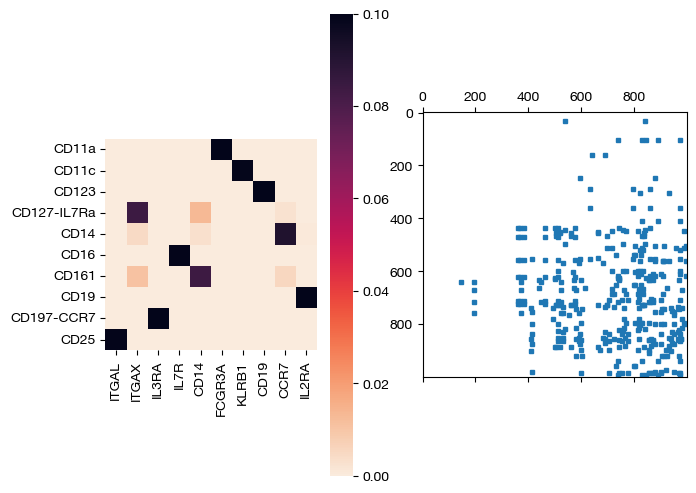

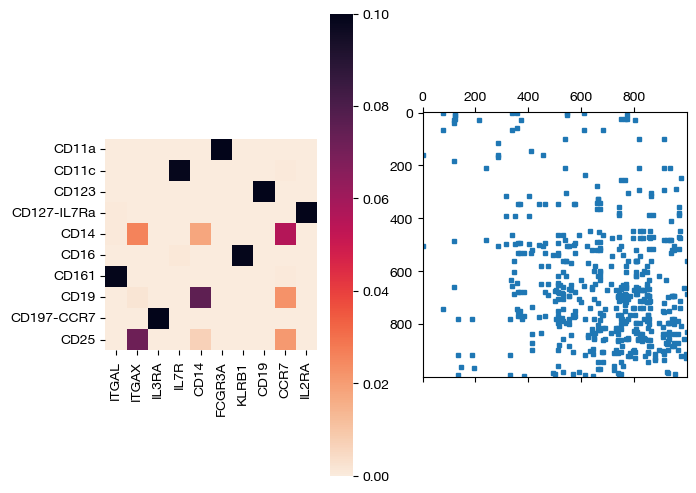

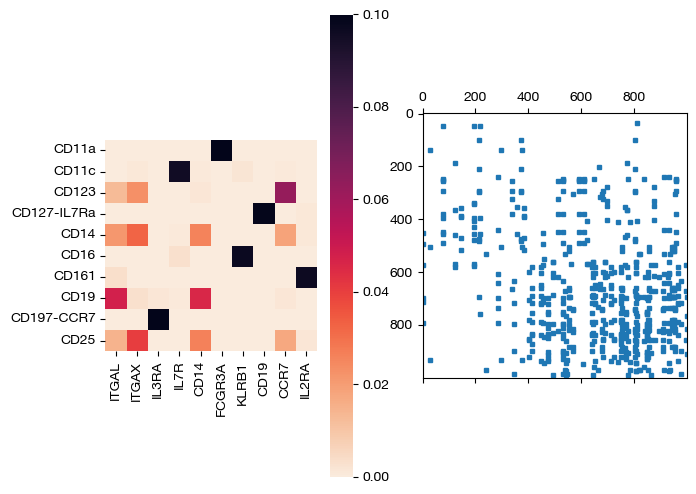

In [84]:
for pi_feat, pi_samp, size in [(pi_feat_ncoot, pi_samp_ncoot, 'alpha=0'), (pi_feat_half, pi_samp_half, 'alpha=0.5'), (np.ones((10, 10))/100, pi_samp_ngw, 'alpha=1')]:
    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(pd.DataFrame(pi_feat, index=adt_annotated.columns, columns=rna_annotated.columns), ax=ax1, cmap='Blues', square=True)
    sns.heatmap(pi_samp[0:100, 0:100],cmap='Blues')
    plt.show()

Note that the middle matrices, $\alpha=0.5$, appear to be somewhere in between the equivalent matrices for $\alpha=0$ and $\alpha=1$. We recommend linearly searching over $\alpha$, as some datasets benefit more from focus on local geometry (high alpha), while some benefit from more focus on feature correspondence (low alpha, when features have strong relationships). As an example:

In [18]:
# an example of alpha search
pi_samp_dt = {}
pi_feat_dt = {}
# for val in np.linspace(start=0, stop=-1, num=10):
    # pi_samp_dt[val], _, pi_feat_dt[val] = scot.agw(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), D_adt_knn, D_rna_knn, alpha=val, eps=eps)

### Supervision (Extension of Fused Formulation to AGW)

AGW allows for supervision in a similar way to UCOOT/UGW; whenever we calculate the local cost of an individual OT problem with respect to some matrix $\pi$ that is subject to supervision via a $\beta \langle D, \pi \rangle$ term, we add $\beta*D$ to the local cost matrix. In particular, we can input our supervision to D = (D_samp, D_feat) as usual. In order to examine how supervision can help, let's try supervising on the feature level and seeing how the scores improve.

```{note}
AGW uses the same beta parameter we had in UCOOT/UGW supervision. Always take a look at your local cost matrices before assigning beta, as your supervision should be relative to the magnitude of the costs the algorithm is applying.
```

In [ ]:
D_feat = torch.from_numpy(-1*np.identity(10, dtype='float32') + np.ones((10, 10), dtype='float32')).to(device)

pi_samp_unsup, _, pi_feat_unsup = scot.agw(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), D_adt_knn, D_rna_knn, alpha=0.1, eps=1e-2, verbose=False)

pi_samp_medsup, _, pi_feat_medsup = scot.agw(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), D_adt_knn, D_rna_knn, alpha=0.1, eps=1e-2, beta=(0, 1e-1), D=(0, D_feat), verbose=False)

pi_samp_fullsup, _, pi_feat_fullsup = scot.agw(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), D_adt_knn, D_rna_knn, alpha=0.1, eps=1e-2, beta=(0, 5), D=(0, D_feat), verbose=False)

In [ ]:
aligned_rna_unsup = get_barycentre(adt, pi_samp_unsup)
aligned_rna_medsup = get_barycentre(adt, pi_samp_medsup)
aligned_rna_fullsup = get_barycentre(adt, pi_samp_fullsup)

We can score and visualize:

In [ ]:
for aligned_rna, mode in [(aligned_rna_unsup, 'unsupervised'), (aligned_rna_medsup, 'some supervision'), (aligned_rna_fullsup, 'full supervision')]:
    fracs = calc_domainAveraged_FOSCTTM(adt, aligned_rna.numpy())
    legend_label="AGW alignment FOSCTTM \n average value for {0}: ".format(mode)+str(np.mean(fracs))
    plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
    plt.legend()
    plt.xlabel("Cells")
    plt.ylabel("Sorted FOSCTTM")
    plt.show()

In [ ]:
for pi_feat, pi_samp, mode in [(pi_feat_unsup, pi_samp_unsup, 'unsupervised'), (pi_feat_medsup, pi_samp_medsup, 'some supervision'), (pi_feat_fullsup, pi_samp_fullsup, 'full supervision')]:
    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    sns.heatmap(pd.DataFrame(pi_feat, index=adt_annotated.columns, columns=rna_annotated.columns), ax=ax1, cmap='Blues', square=True)
    ax2.spy(pi_samp, precision=0.0001, markersize=3)
    plt.show()

As we can see, feature level supervision greatly aids sample level alignment, as expected!

In one of our future application notebooks, we will examine potential ways to generate sample and feature supervision matrices given cell types (sample supervision) and prior knowledge (feature supervision).

We have now concluded the AGW tutorial. The key differences between AGW and UCOOT/UGW are:

1. AGW uses $\alpha$ to denote the GW/COOT balance, rather than a supervision coefficient.
3. AGW does not allow for marginal relaxation at the moment.
4. AGW brings together GW/COOT simultaneously to improve alignment quality and account for both feature correspondence as well as local geometry.

Now that you have reached this stage, we recommend viewing our application notebooks, which will be rolling out soon! These tutorials have attempted to help give you intuition for the parameters, algorithms, etc., but they do not display well what to do in practice on unpaired datasets and how to score these circumstances. Continue on to learn more about how AGW can better align your data.

Citations:

Pinar Demetci, Quang Huy Tran, Ievgen Redko, Ritambhara Singh. Revisiting invariances and introducing priors in Gromov-Wasserstein distances. arXiv, stat.ML, 2023.